## Overview ## 

This project analyzes databases of movie to recommend the best movie studio to invest in.

## Business Problem ##

Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

## Data Preparation ##

In [68]:
# import the necessary Python packages for analysis, computation, and visualization
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [69]:
#loading all the datasets
bom_movie_gross_data = pd.read_csv("zippedData/bom.movie_gross.csv.gz", compression="gzip")
rt_movie_info_data = pd.read_csv("zippedData/rt.movie_info.tsv.gz", compression="gzip", sep="\t", encoding="unicode_escape")
rt_reviews_data = pd.read_csv("zippedData/rt.reviews.tsv.gz", compression="gzip", sep="\t", encoding="unicode_escape")
tmdb_movies_data = pd.read_csv("zippedData/tmdb.movies.csv.gz", compression="gzip")
movie_budgets_data = pd.read_csv("zippedData/tn.movie_budgets.csv.gz", compression="gzip")

In [70]:
conn = sqlite3.connect("im.db")
cur = conn.cursor()

In [71]:
# pd.read_sql("""
#     SELECT *
#     FROM movie_basics;
# """, conn)

In [72]:
#  pd.read_sql("""
#     SELECT *
#     FROM movie_ratings;
# """, conn)

##  Data Understanding ##

This data includes information from Rotten Tomatoes(RT), Box Office Mojo(BOM), The Movie Database(TMDB), The Numbers(TN), and Internet Movie Database(IMDB).


## Who is our Audience ##
Our first approach is determining our target audience for our movie studio. Our focus is analyzing two databases from Rotten Tomatoes, specifically the Box Office and Movie Rating columns to see how much profit is made within each category. From there, we will use the film rating system to come up with a general age demographic. 

In [73]:
#Merging the two datasets from Rotten Tomatoes, focusing on the movie_ratings and box office. 
merge_data = rt_movie_info_data.merge(rt_reviews_data, how="inner", on="id")

In [74]:
#renaming the two rating columns 
merge_data = merge_data.rename(columns={'rating_x':'movie_rating', 'rating_y':'review_rating'})

In [75]:
#replace the letter grades into numeric values
merge_data["review_rating"] = merge_data["review_rating"].replace({'A+':'15/15',
                                                 'A':'14/15',
                                                 'A-':'13/15',
                                                 'B+':'12/15',
                                                 'B':'11/15',
                                                 'B-':'10/15',
                                                 'C+':'9/15',
                                                 'C':'8/15',
                                                 'C-':'7/15',
                                                 'D+':'6/15',
                                                 'D':'5/15',
                                                 'D-':'4/15',
                                                 'F+':'3/15',
                                                 'F':'2/15',
                                                 'F-':'1/15'})

In [76]:
#dropping the null values
merge_data.dropna(subset=['review_rating'], inplace=True)

In [77]:
#dropping these miscellaneous values 
merge_data = merge_data[merge_data['review_rating'] != 'T']
merge_data = merge_data[merge_data['review_rating'] != '1-5']
merge_data = merge_data[merge_data['review_rating'] != 'R']
merge_data = merge_data[merge_data['review_rating'] != 'N']
merge_data = merge_data[merge_data['review_rating'] != '3 1/2']

In [78]:
#strings values to fractions 
import string 
letters = string.ascii_uppercase

def to_decimal(fraction):
    if isinstance(fraction, str):
        try:
            a, b = fraction.split('/')
            x  = round((float(a) / float(b)), 2)
            return x
        except ValueError:
            return fraction
    else:
        return fraction
    
merge_data['review_rating'] = merge_data['review_rating'].map(lambda x: to_decimal(x) if x is not letters else x )

In [79]:
merge_data['review_rating'] = pd.to_numeric(merge_data['review_rating'])

In [80]:
#Assume the values greater than 1 are out of 10
def out_of_ten(ele):
    if ele > 1:
        return round(ele/10, 2)
    else:
        return ele
merge_data['review_rating'] = merge_data['review_rating'].map(out_of_ten)

In [81]:
#dropping the null values in the box_office column
merge_data.dropna(subset=['box_office'], inplace=True)

In [82]:
#removing the commas in the box_office column
merge_data['box_office'] = merge_data['box_office'].replace({',': ''}, regex=True)

In [83]:
#turning the values into numbers
merge_data['box_office'] = pd.to_numeric(merge_data['box_office'])

In [84]:
unique_data = merge_data.drop_duplicates(subset=['id'])
unique_data

,id,synopsis,movie_rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,review,review_rating,fresh,critic,top_critic,publisher,date
0,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000,108 minutes,Entertainment One,A distinctly gallows take on contemporary fina...,0.60,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
318,10,Some cast and crew from NBC's highly acclaimed...,PG-13,Comedy,Jake Kasdan,Mike White,"Jan 11, 2002","Jun 18, 2002",$,41032915,82 minutes,Paramount Pictures,"It won't stick with you forever, but you will ...",0.60,fresh,NaN,0,Film4,"August 12, 2008"
426,13,"Stewart Kane, an Irishman living in the Austra...",R,Drama,Ray Lawrence,Raymond Carver|Beatrix Christian,"Apr 27, 2006","Oct 2, 2007",$,224114,123 minutes,Sony Pictures Classics,"Subtle and understated, a meditation on morali...",0.88,fresh,Jeff Simon,0,Buffalo News,"April 9, 2018"
521,14,"""Love Ranch"" is a bittersweet love story that ...",R,Drama,Taylor Hackford,Mark Jacobson,"Jun 30, 2010","Nov 9, 2010",$,134904,117 minutes,NaN,A captivating film... [Full review in Spanish],0.60,fresh,Laura Hiros,0,NaN,"March 22, 2018"
726,23,A fictional film set in the alluring world of ...,R,Drama,NaN,NaN,"Dec 20, 2013","Mar 18, 2014",$,99165609,129 minutes,Sony Pictures,The movie is great. It is interesting without ...,0.80,fresh,Debbie Baldwin,0,Ladue News,"November 2, 2018"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53567,1976,"Embrace of the Serpent features the encounter,...",NR,Action and Adventure|Art House and International,Ciro Guerra,Ciro Guerra|Jacques Toulemonde Vidal,"Feb 17, 2016","Jun 21, 2016",$,1320005,123 minutes,Buffalo Films,The journey is definitely the destination in E...,0.88,fresh,Lisa Jensen,0,Good Times Santa Cruz,"September 11, 2017"
53717,1980,A band of renegades on the run in outer space ...,PG-13,Action and Adventure|Science Fiction and Fantasy,Joss Whedon,Joss Whedon,"Sep 30, 2005","Dec 20, 2005",$,25335935,119 minutes,Universal Pictures,"Thank you, [Joss], for creating this world, fo...",1.00,fresh,Aaron Peterson,0,The Hollywood Outsider,"October 25, 2018"
53887,1981,"Money, Fame and the Knowledge of English. In I...",NR,Comedy|Drama,Gauri Shinde,Gauri Shinde,"Oct 5, 2012","Nov 20, 2012",$,1416189,129 minutes,Eros Entertainment,A capable supporting cast and a fun cameo from...,0.60,fresh,Anil Sinanan,1,Time Out,"October 23, 2017"
53891,1986,Aki Kaurismaki's The Man Without a Past opens ...,PG,Art House and International|Comedy|Drama,NaN,NaN,"Aug 30, 2002","Oct 7, 2003",$,794306,97 minutes,NaN,...dourly delightful.,0.88,fresh,Josh Larsen,0,LarsenOnFilm,"May 19, 2016"


In [85]:
unique_data

,id,synopsis,movie_rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,review,review_rating,fresh,critic,top_critic,publisher,date
0,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000,108 minutes,Entertainment One,A distinctly gallows take on contemporary fina...,0.60,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
318,10,Some cast and crew from NBC's highly acclaimed...,PG-13,Comedy,Jake Kasdan,Mike White,"Jan 11, 2002","Jun 18, 2002",$,41032915,82 minutes,Paramount Pictures,"It won't stick with you forever, but you will ...",0.60,fresh,NaN,0,Film4,"August 12, 2008"
426,13,"Stewart Kane, an Irishman living in the Austra...",R,Drama,Ray Lawrence,Raymond Carver|Beatrix Christian,"Apr 27, 2006","Oct 2, 2007",$,224114,123 minutes,Sony Pictures Classics,"Subtle and understated, a meditation on morali...",0.88,fresh,Jeff Simon,0,Buffalo News,"April 9, 2018"
521,14,"""Love Ranch"" is a bittersweet love story that ...",R,Drama,Taylor Hackford,Mark Jacobson,"Jun 30, 2010","Nov 9, 2010",$,134904,117 minutes,NaN,A captivating film... [Full review in Spanish],0.60,fresh,Laura Hiros,0,NaN,"March 22, 2018"
726,23,A fictional film set in the alluring world of ...,R,Drama,NaN,NaN,"Dec 20, 2013","Mar 18, 2014",$,99165609,129 minutes,Sony Pictures,The movie is great. It is interesting without ...,0.80,fresh,Debbie Baldwin,0,Ladue News,"November 2, 2018"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53567,1976,"Embrace of the Serpent features the encounter,...",NR,Action and Adventure|Art House and International,Ciro Guerra,Ciro Guerra|Jacques Toulemonde Vidal,"Feb 17, 2016","Jun 21, 2016",$,1320005,123 minutes,Buffalo Films,The journey is definitely the destination in E...,0.88,fresh,Lisa Jensen,0,Good Times Santa Cruz,"September 11, 2017"
53717,1980,A band of renegades on the run in outer space ...,PG-13,Action and Adventure|Science Fiction and Fantasy,Joss Whedon,Joss Whedon,"Sep 30, 2005","Dec 20, 2005",$,25335935,119 minutes,Universal Pictures,"Thank you, [Joss], for creating this world, fo...",1.00,fresh,Aaron Peterson,0,The Hollywood Outsider,"October 25, 2018"
53887,1981,"Money, Fame and the Knowledge of English. In I...",NR,Comedy|Drama,Gauri Shinde,Gauri Shinde,"Oct 5, 2012","Nov 20, 2012",$,1416189,129 minutes,Eros Entertainment,A capable supporting cast and a fun cameo from...,0.60,fresh,Anil Sinanan,1,Time Out,"October 23, 2017"
53891,1986,Aki Kaurismaki's The Man Without a Past opens ...,PG,Art House and International|Comedy|Drama,NaN,NaN,"Aug 30, 2002","Oct 7, 2003",$,794306,97 minutes,NaN,...dourly delightful.,0.88,fresh,Josh Larsen,0,LarsenOnFilm,"May 19, 2016"


In [86]:
unique_data['theater_date'] = pd.to_datetime(unique_data['theater_date'])

/var/folders/wr/g705p4v548q9pr0f6xzqsgmw0000gn/T/ipykernel_2274/829853311.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_data['theater_date'] = pd.to_datetime(unique_data['theater_date'])


In [87]:
unique_data['runtime'] = unique_data['runtime'].replace({'minutes': ''}, regex=True)
unique_data['runtime'] = pd.to_numeric(unique_data['runtime'])

/var/folders/wr/g705p4v548q9pr0f6xzqsgmw0000gn/T/ipykernel_2274/945231224.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_data['runtime'] = unique_data['runtime'].replace({'minutes': ''}, regex=True)
/var/folders/wr/g705p4v548q9pr0f6xzqsgmw0000gn/T/ipykernel_2274/945231224.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_data['runtime'] = pd.to_numeric(unique_data['runtime'])


In [88]:
roi_data = pd.read_csv("budget_imdb.csv")
roi_data

,Unnamed: 0,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,roi
0,0,1,2009-12-18,Avatar,425000000,760507625,2776345279,tt1775309,Avatar,Abatâ,2011,93.0,['Horror'],6.1,43,6.532577
1,1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.0,"['Action', 'Adventure', 'Fantasy']",6.6,447624,2.546673
2,2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,tt6565702,Dark Phoenix,Dark Phoenix,2019,113.0,"['Action', 'Adventure', 'Sci-Fi']",6.0,24451,0.427892
3,3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.0,"['Action', 'Adventure', 'Sci-Fi']",7.3,665594,4.243841
4,4,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,"['Action', 'Adventure', 'Sci-Fi']",8.5,670926,6.827114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2870,2870,62,2014-12-31,Stories of Our Lives,15000,0,0,tt3973612,Stories of Our Lives,Stories of Our Lives,2014,60.0,['Drama'],7.5,85,0.000000
2871,2871,68,2001-07-06,Cure,10000,94596,94596,tt1872026,Cure,Cure,2011,93.0,['Drama'],4.9,11,9.459600
2872,2872,73,2012-01-13,Newlyweds,9000,4584,4584,tt1880418,Newlyweds,Newlyweds,2011,95.0,"['Comedy', 'Drama']",6.4,1436,0.509333
2873,2873,78,2018-12-31,Red 11,7000,0,0,tt7837402,Red 11,Red 11,2019,77.0,"['Horror', 'Sci-Fi', 'Thriller']",5.6,43,0.000000


In [89]:
roi_data.dropna(subset=['release_date'])
roi_data['release_date'] = pd.to_datetime(roi_data['release_date'])

In [90]:
roi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2875 entries, 0 to 2874
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0         2875 non-null   int64         
 1   id                 2875 non-null   int64         
 2   release_date       2875 non-null   datetime64[ns]
 3   movie              2875 non-null   object        
 4   production_budget  2875 non-null   int64         
 5   domestic_gross     2875 non-null   int64         
 6   worldwide_gross    2875 non-null   int64         
 7   movie_id           2875 non-null   object        
 8   primary_title      2875 non-null   object        
 9   original_title     2875 non-null   object        
 10  start_year         2875 non-null   int64         
 11  runtime_minutes    2757 non-null   float64       
 12  genres             2867 non-null   object        
 13  averagerating      2875 non-null   float64       
 14  numvotes

In [91]:
merge_data2 = unique_data.merge(roi_data, how="inner", left_on=["theater_date", "runtime"], right_on=["release_date", "runtime_minutes"])
merge_data2

,id_x,synopsis,movie_rating,genre,director,writer,theater_date,dvd_date,currency,box_office,...,worldwide_gross,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,roi
0,14,"""Love Ranch"" is a bittersweet love story that ...",R,Drama,Taylor Hackford,Mark Jacobson,2010-06-30,"Nov 9, 2010",$,134904,...,146149,tt1125929,Love Ranch,Love Ranch,2010,117.0,"['Biography', 'Comedy', 'Drama']",5.6,2742,0.005846
1,95,BLEED FOR THIS is the incredible true story of...,R,Drama|Sports and Fitness,Ben Younger,Ben Younger,2016-11-18,"Feb 14, 2017",$,5051927,...,32398681,tt4550098,Nocturnal Animals,Nocturnal Animals,2016,116.0,"['Drama', 'Thriller']",7.5,205240,1.439941
2,188,From the producers of Little Miss Sunshine - W...,R,Comedy|Drama,Colin Trevorrow,Derek Connolly,2012-06-08,"Oct 30, 2012",$,4007792,...,4422318,tt1862079,Safety Not Guaranteed,Safety Not Guaranteed,2012,86.0,"['Comedy', 'Drama', 'Romance']",7.0,111907,5.896424
3,251,"In this adaptation of the novel ""The Price of ...",R,Drama|Romance,Todd Haynes,Phyllis Nagy,2015-11-20,"Mar 15, 2016",$,8518148,...,42843521,tt2402927,Carol,Carol,2015,118.0,"['Drama', 'Romance']",7.2,100680,3.630807
4,300,Liz Gilbert had everything a modern woman is s...,PG-13,Drama,Ryan Murphy,Ryan Murphy|Jennifer Salt,2010-08-13,"Nov 23, 2010",$,80574010,...,206598789,tt0879870,Eat Pray Love,Eat Pray Love,2010,133.0,"['Drama', 'Romance']",5.8,77709,3.443313
5,322,When her heart is stolen by a seductive strang...,R,Horror,Guillermo del Toro,Guillermo del Toro|Matthew Robbins|Lucinda Coxon,2015-10-16,"Feb 9, 2016",$,25957696,...,74966854,tt2554274,Crimson Peak,Crimson Peak,2015,119.0,"['Drama', 'Fantasy', 'Horror']",6.5,119287,1.363034
6,482,"Take out the trash, eat your broccoli-who need...",PG,Action and Adventure|Animation|Comedy|Science ...,Simon Wells,Simon Wells|Wendy Wells,2011-03-11,"Aug 9, 2011",$,21379315,...,39549758,tt1305591,Mars Needs Moms,Mars Needs Moms,2011,88.0,"['Adventure', 'Animation', 'Family']",5.4,19823,0.263665
7,482,"Take out the trash, eat your broccoli-who need...",PG,Action and Adventure|Animation|Comedy|Science ...,Simon Wells,Simon Wells|Wendy Wells,2011-03-11,"Aug 9, 2011",$,21379315,...,39475,tt1314190,3 Backyards,3 Backyards,2010,88.0,['Drama'],5.0,611,0.131583
8,610,American tourist Frank (Johnny Depp) meets a m...,PG-13,Action and Adventure|Mystery and Suspense|Romance,Florian Henckel von Donnersmarck,Florian Henckel von Donnersmarck|Christopher M...,2010-12-10,"Mar 22, 2011",$,67631157,...,278731369,tt1243957,The Tourist,The Tourist,2010,103.0,"['Action', 'Adventure', 'Thriller']",6.0,206714,2.787314
9,674,When 22 year-old drug dealer Chris (Hirsch) ha...,R,Comedy|Mystery and Suspense,William Friedkin,Tracy Letts,2012-07-27,"Dec 21, 2012",$,1800000,...,67130045,tt1298649,The Watch,The Watch,2012,102.0,"['Action', 'Comedy', 'Horror']",5.7,115757,1.220546


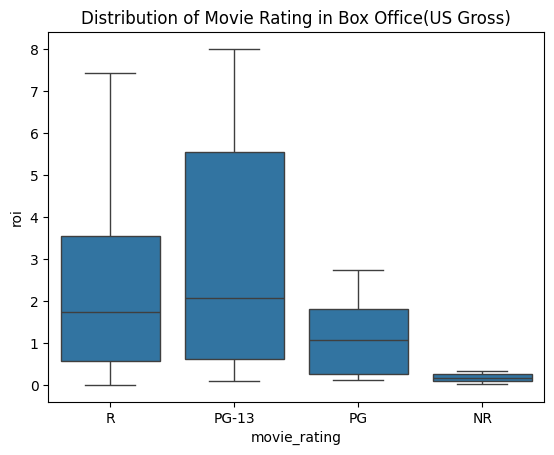

In [92]:
sns.boxplot(data=merge_data2, x=merge_data2["movie_rating"], 
            y=merge_data2["roi"]).set_title("Distribution of Movie Rating in Box Office(US Gross)")
plt.savefig("boxplot_review_movie.png");

In [93]:
merge_data2['movie_rating'].value_counts()

movie_rating
R        22
PG-13    11
PG        5
NR        2
Name: count, dtype: int64

In [94]:
roi_mean = roi_data['roi'].mean()
pg13_sample = merge_data2[merge_data2['movie_rating'] == 'PG-13']['roi']

In [95]:
roi_mean

4.109374708457201

In [96]:
pg13_sample.mean()

3.1497731016497137

In [97]:
stats.ttest_1samp(a = pg13_sample, popmean = roi_mean, alternative="greater") #dont have enough samples 
#failed to reject the null hypothesis

TtestResult(statistic=-0.9838700725150024, pvalue=0.8258077164717776, df=10)

In [98]:
pg_sample = merge_data2[merge_data2['movie_rating'] == 'PG']['roi']
stats.ttest_1samp(a = pg_sample, popmean = roi_mean, alternative="less")

TtestResult(statistic=-5.935485034831267, pvalue=0.0020196605043971833, df=4)

In [99]:
r_sample = merge_data2[merge_data2['movie_rating'] == 'R']['roi']
stats.ttest_1samp(a = r_sample, popmean = roi_mean, alternative="greater")

TtestResult(statistic=-4.124152139133418, pvalue=0.9997585620911366, df=21)

In [100]:
#statistical summary of box office revenue on movie rating
df = unique_data.groupby(['movie_rating'])['box_office'].agg([np.mean, np.median, np.max, np.min, np.sum])
df = df.sort_values(by="mean", ascending=False)
df

/var/folders/wr/g705p4v548q9pr0f6xzqsgmw0000gn/T/ipykernel_2274/2195697296.py:2: FutureWarning: The provided callable <function mean at 0x1057b0c10> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = unique_data.groupby(['movie_rating'])['box_office'].agg([np.mean, np.median, np.max, np.min, np.sum])
/var/folders/wr/g705p4v548q9pr0f6xzqsgmw0000gn/T/ipykernel_2274/2195697296.py:2: FutureWarning: The provided callable <function median at 0x105c3b820> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df = unique_data.groupby(['movie_rating'])['box_office'].agg([np.mean, np.median, np.max, np.min, np.sum])
/var/folders/wr/g705p4v548q9pr0f6xzqsgmw0000gn/T/ipykernel_2274/2195697296.py:2: FutureWarning: The provided callable <function amax a

,mean,median,amax,amin,sum
movie_rating,,,,,
PG-13,5.603056e+07,32741596.0,303001229,200000,5995270396
PG,5.045734e+07,25077977.0,261835892,118253,2270580405
R,2.554368e+07,8326182.5,368000000,8300,3218503413
G,2.284580e+07,13592311.0,106604314,598103,159920588
NR,6.628353e+05,450143.5,1626289,363,9279694


In [101]:
import dataframe_image as dfi
dfi.export(df, "movie_rating_summary.png")

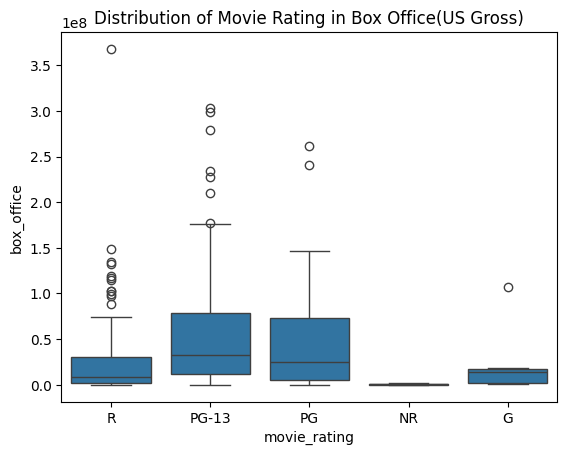

In [102]:
sns.boxplot(data=unique_data, x=unique_data["movie_rating"], 
            y=unique_data["box_office"]).set_title("Distribution of Movie Rating in Box Office(US Gross)")
plt.savefig("boxplot_review_movie.png");

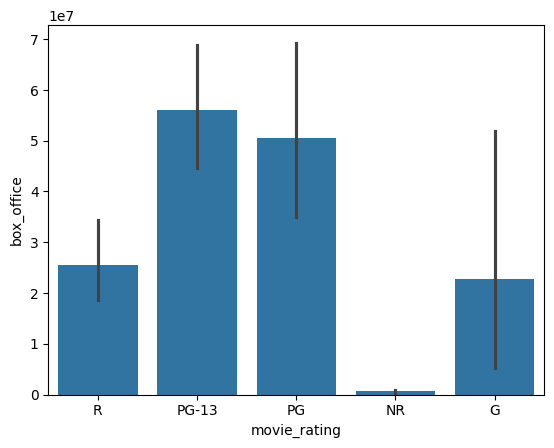

In [103]:
sns.barplot(data=unique_data, x=unique_data['movie_rating'], y=unique_data['box_office']);

In [104]:
df2 = unique_data.groupby(['movie_rating'])['box_office'].sum()
df2

movie_rating
G         159920588
NR          9279694
PG       2270580405
PG-13    5995270396
R        3218503413
Name: box_office, dtype: int64

In [105]:
mr = ["G", "NR", "PG", "PG-13", "R"]
summed = [159920588, 9279694, 2270580405, 5995270396, 3218503413]
total = sum(summed)

normalized = []

for ele in summed:
    normalize = int(ele)/total
    normalized.append(normalize)

print(normalized)

[0.013722902145855293, 0.0007962973016675032, 0.19484015849236047, 0.5144585197638912, 0.27618212229622546]


In [106]:
dict = {"Movie Rating": mr, "Box Office values": summed, "Normalized values": normalized}
normalized_df = pd.DataFrame(dict)
normalized_df

,Movie Rating,Box Office values,Normalized values
0,G,159920588,0.013723
1,NR,9279694,0.000796
2,PG,2270580405,0.194840
3,PG-13,5995270396,0.514459
4,R,3218503413,0.276182


In [107]:
#normalized_df.to_csv('normalized_df.csv')

In [108]:
# merge_data.to_csv('merge_data.csv') 
# unique_data.to_csv("unique_data.csv")

We can see from our boxplot and bar graph that PG-13 performs the best in the box office compared to the other ratings. Thus, we can conclude our target demographic is anyone ages of 13 and up. 

## The Numbers ROI ##

In [109]:
movie_budgets_data.domestic_gross = movie_budgets_data.domestic_gross.map(lambda x: int(x.strip('$').replace(',', '')))
movie_budgets_data.worldwide_gross = movie_budgets_data.worldwide_gross.map(lambda x: int(x.strip('$').replace(',', '')))
movie_budgets_data.production_budget = movie_budgets_data.production_budget.map(lambda x: int(x.strip('$').replace(',', '')))

In [31]:
movie_budgets_data[movie_budgets_data.domestic_gross < movie_budgets_data.worldwide_gross]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747
...,...,...,...,...,...,...
5759,60,"Jun 2, 2006",The Puffy Chair,15000,194523,195254
5773,74,"Feb 26, 1993",El Mariachi,7000,2040920,2041928
5774,75,"Oct 8, 2004",Primer,7000,424760,841926
5775,76,"May 26, 2006",Cavite,7000,70071,71644


## Conclusion ##